# Example with OpenBCI

Instantiate `openbci` for data acquisition, A full guide can be consulted in [OpenBCI - Data Acquisition](https://openbci.readthedocs.io/en/latest/_notebooks/data_acquisition.html)

In [4]:
from openbci.acquisition import CytonRFDuino

montage = "Fp1 Fp2 F3 Fz F4 T3 C3 Cz C4 T4 P3 Pz P4 O1 O2".split()

openbci = CytonRFDuino(montage=montage)
openbci.command(openbci.BOARD_MODE_MARKER)

b'Success: marker$$$'

Instantiate `gym_bci` for the stimuli:

In [5]:
import gym
import gym_bci

environment_config = {
    'maintain': 1000,  
    'min_delay': 200,  
    'max_delay': 800,  
    'button_start': False,
}

env = gym.make('bci-arrows-v0')
env.reset(**environment_config)

/home/yeison/Development/gcpds/gym-bci/notebooks/gym_bci/envs/pacman


Each stimulus must have a unique marker.

In [7]:
markers_for_actions = {
    'right': 10,
    'left': 20,
#     'up': 30,
#     'down': 40,
}

In [9]:
session_config = {
    
    'trials': 4,
    'start_marker': 50,
    'end_marker': 60,
    
}

The cues consist of a shuffled array of actions

In [19]:
import numpy as np

actions = list(markers_for_actions.keys())
trials_per_action = session_config['trials']//len(actions)

cues = np.array([[action] * trials_per_action for action in actions]).reshape(-1)
np.random.shuffle(cues)

cues

array(['left', 'left', 'right', 'right'], dtype='<U5')

The main acquisition and stimuli process, is very simple:

In [ ]:
import time
from datetime import datetime

now = datetime.now()
now = str(now).replace(':', '_')

# start acquisition
openbci.start_collect()
time.sleep(1)  # pause for ensuring the device initialization
openbci.send_marker(session_config['start_marker'])
time.sleep(1)  # other pause for separate the first marker

# cues
for cue in cues:
    openbci.send_marker(markers_for_actions[cue])  # send the cue marker
    env.step(cue)  # display the cue
    
# stop acquisition
time.sleep(1)
openbci.send_marker(session_config['end_marker'])
time.sleep(1)
openbci.stop_collect()
openbci.close()
time.sleep(1)  # pause for ensuring data storage

# close stimuli window
env.close()

Acces to eeg data:

In [91]:
eeg_data = np.array(openbci.eeg_buffer.queue).T
sample, eeg, aux, footer, datetime = eeg_data
eeg =  np.stack(eeg).T
eeg.shape

(15, 2669)

Generate the time vetor:

In [93]:
time = np.linspace(0, (datetime[-1] - datetime[0]).total_seconds(), eeg.shape[1])

Display the acquired data:

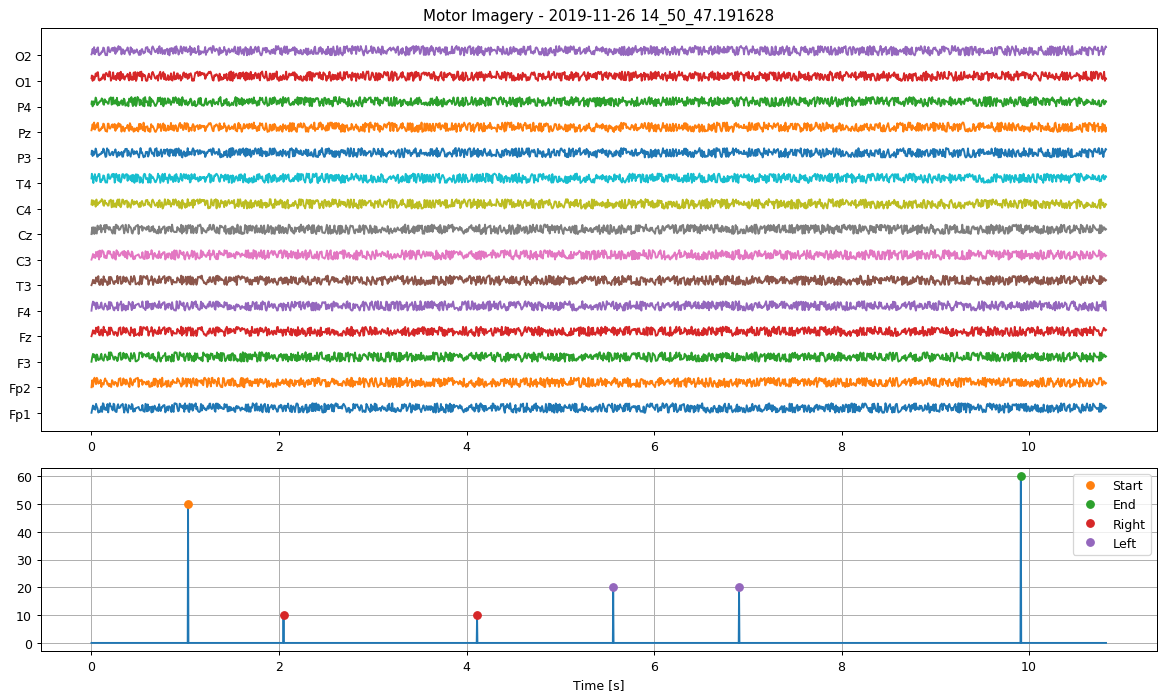

In [95]:
%matplotlib inline 

from matplotlib import pyplot
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

figure = pyplot.figure(figsize=(16, 9), dpi=90)
gridsize = (3, 1)

ax1 = pyplot.subplot2grid(gridsize, (0, 0), rowspan=2)
pyplot.title(f"Motor Imagery - {now}")

for i, eeg_ in enumerate(eeg):
    pyplot.plot(time, eeg_ + i)
    
ax1.set_yticks(list(openbci.montage.keys()))
ax1.set_yticklabels(openbci.montage.values())

ax2 = pyplot.subplot2grid(gridsize, (2, 0))
pyplot.plot(time, aux)

start = (np.where(aux == session_config['start_marker'])[0])
end = (np.where(aux == session_config['end_marker'])[0])
markers_points = [(k, np.where(aux == markers_for_actions[k])[0]) for k in markers_for_actions]

pyplot.plot(time[start], aux[start], 'o', label='Start')
pyplot.plot(time[end], aux[end], 'o', label='End')

for marker, points in markers_points:
    pyplot.plot(time[points], aux[points], 'o', label=marker.capitalize())
    
pyplot.xlabel("Time [s]")
    
pyplot.grid(True)
pyplot.legend()
pyplot.show()

Save the acquired data:

In [97]:
import os
import json

# filename
if not os.path.exists('data'):
    os.mkdir('data')
filename_path = os.path.join('data',  now)
 
# save figure
figure.savefig(f"{filename_path}.png")

# save csv
to_save = np.concatenate([eeg, np.stack([aux])]).T
np.savetxt(f"{filename_path}.csv", to_save, delimiter=',')

# save json
with open(f"{filename_path}.json", 'w') as fp:
    
    data = environment_config.copy()
    data.update({f"{k}_marker":markers_for_actions[k] for k in markers_for_actions})
    data.update(session_config)
    
    data['datetime'] = now.replace('_', ':')
    data['sample_rate'] = f"{aux.shape[0]/time[-1]:.2f} Hz"
    data['channels'] = ", ".join(openbci.montage.values())
    data["channels_system"] = "10-20"

    json.dump(data, fp, indent=4)
    
print(f"saved as: {filename_path}")

saved as: data/2019-11-26 14_50_47.191628
